In [4]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 5.2 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
import xgboost as xgb
import matplotlib.pyplot as plt

### Data Simulation

In [6]:
np.random.seed(42)
n_samples = 1000

# Simulate features
df = pd.DataFrame({
    'interest_rate': np.random.uniform(2.5, 6.5, n_samples),
    'credit_score': np.random.normal(700, 50, n_samples),
    'ltv': np.random.uniform(60, 100, n_samples),
    'loan_term': np.random.choice([15, 30], n_samples),
    'income': np.random.normal(75000, 15000, n_samples)
})

df['credit_score'] = df['credit_score'].clip(300, 850)
df['income'] = df['income'].clip(20000, 200000)

### Model Equation Entries

In [7]:
# True coefficients for logistic link
beta = {
    'intercept': -5,
    'interest_rate': 0.6,
    'credit_score': -0.005,
    'ltv': 0.04,
    'loan_term': -0.1,
    'income': 0.00001
}

log_odds = (
    beta['intercept'] +
    beta['interest_rate'] * df['interest_rate'] +
    beta['credit_score'] * df['credit_score'] +
    beta['ltv'] * df['ltv'] +
    beta['loan_term'] * df['loan_term'] +
    beta['income'] * df['income']
)

def logistic(x):
    return 1 / (1 + np.exp(-x))

p = logistic(log_odds)

df['prepaid'] = np.random.binomial(1, p)

# Features and target
X = df[['interest_rate', 'credit_score', 'ltv', 'loan_term', 'income']]
y = df['prepaid']

### Trian with ML, XGBoost, Plotting

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:11:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Test ROC AUC: 0.7606
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       291
           1       0.33      0.11      0.17         9

    accuracy                           0.97       300
   macro avg       0.65      0.55      0.57       300
weighted avg       0.95      0.97      0.96       300



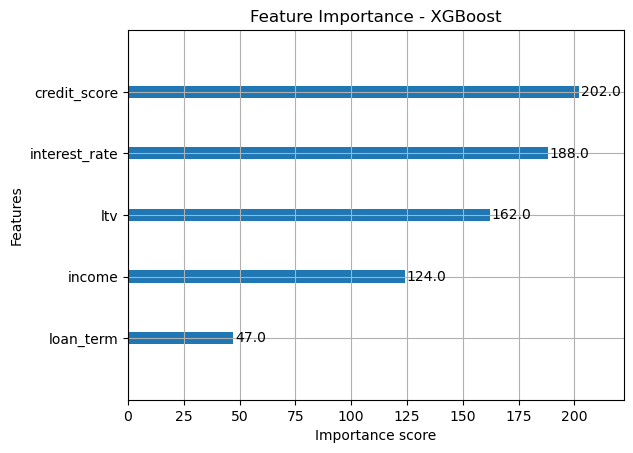

In [8]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train XGBoost classifier
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train, y_train)

# Predict probabilities and classes
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

# Evaluate with ROC AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test ROC AUC: {auc:.4f}")

# Classification report
print(classification_report(y_test, y_pred))

# Feature importance plot
xgb.plot_importance(model)
plt.title("Feature Importance - XGBoost")
plt.show()
